# Tutorial
In this tutorial, we will go through how to use `igPCA` to perform the igPCA framework for two dataset

## Quick Recap of igPCA
Suppose we have two structured views $(X_1, H, Q_1)$ and $(X_2, H, Q_2)$ collected from the same set of individuals.
Without loss of generality, we assume each dataset has been scaled by its total variation such that $||X_i||_{H,Q_i}=1$. Naively, we first consider the following decomposition
$$ X_i  = J_i + A_i + E_i \quad  i=1,2 \\
E_i  \sim \mathcal{MN}(0, H^{-1} , Q_i^{-1})
$$

where $J_i$ is the matrix capturing the joint latent structures, $A_i$ the individual structures for each dataset $i$, and the error matrix $E_i$ has two-way structures coded in $H$ and $Q_i$ such that $E_i \sim \mathcal{MN}(0, H^{-1} , Q_i^{-1})$.

Suppose the rank of $X_1, X_2$ are $r_1$ and $r_2$, and the joint rank is $r_0$, we perform joint dimensionality reduction of $X_1, X_2$ in the following steps.

## The `igPCA` class
The `igPCA` class takes the input data, performs rank selection if necessary and fit the model with pre-specified joint rank or by a user-specifed threshold

In [95]:
from igPCA.igPCA import igPCA
from scipy.linalg import subspace_angles
from numpy import linalg as LA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)

sns.set_theme()

### Simulation Study

#### Helper Function

In [96]:
def square_error(x, y):
    return LA.norm(x-y)


def compute_QH_norm(A, H, Q):
    n, p = np.shape(A)
    numeric_1 = np.matmul(H, A)
    numeric_2 = np.matmul(Q, np.transpose(A))
    result = np.trace(np.matmul(numeric_1, numeric_2))
    return np.sqrt(result)/np.sqrt(n*p)


def principle_angle(A, B):
    angle = subspace_angles(A, B)
    return (1 - np.cos(angle[0]))


def baseline_PCA(X1, X2, k):
    joint_matrix = np.concatenate((X1, X2), axis=1)
    u, s, v = LA.svd(joint_matrix, full_matrices=False, compute_uv=True)
    x_pca = np.dot(u[:, :k]*s[:k], v[:k, :])
    return tuple((u[:, :k], x_pca))


def sym_eig(X):
    val, vec = LA.eig(X)
    sQ = vec @ np.diag(np.sqrt(val)) @ vec.T
    isQ = vec @ np.diag(1/np.sqrt(val)) @ vec.T
    return (tuple((sQ, isQ)))


def coIA(X1, X2, H, Q1, Q2, K):
    sQ1, isQ1 = sym_eig(Q1)
    sQ2, isQ2 = sym_eig(Q2)
    w = sQ1.T @ X1.T @ H @ X2 @ sQ2
    ea, _, eb = LA.svd(w)
    A = ea[:, : K]
    B = eb.T[:, : K]
    V1 = isQ1 @ A
    V2 = isQ2 @ B
    U1 = X1 @ Q1 @ V1
    U2 = X2 @ Q2 @ V2
    return (tuple((U1[:, :K], V1[:, :K], U2[:, :K], V2[:, :K])))

def M_generation(U, V, d):
    s = len(d)
    M = np.dot(d * U[:, :s], V[:, :s].T)
    return M


def normalize_matrix(H):
    t = np.trace(H)
    n = np.shape(H)[0]
    H = H/t*n
    return H


def X_generation(H, Q, M, noise_level):
    n, p = np.shape(M)
    noise = np.random.normal(0, 1, (n, p))
    sigma = normalize_matrix(LA.inv(H))
    phi = normalize_matrix(LA.inv(Q))
    v1, p1 = LA.eig(sigma)
    v2, p2 = LA.eig(phi)
    L = np.matmul(np.matmul(p1, np.sqrt(np.diag(v1))), p1.T)
    R = np.matmul(np.matmul(p2, np.sqrt(np.diag(v2))), p2.T)
    noise = L @ noise @ R
    X = M + noise * noise_level
    return X

#### Generate Data

In [102]:
d01 = [100]
d02 = [80]
d11 = [70]
d12 = [40]
noise_1 = 0.8
noise_2 = 0.8
r0 = 1
r1 = 2
r2 = 2

# read data
U = np.loadtxt('../simulation_settings/U_0.8.csv', delimiter=",", dtype=float)
H = np.loadtxt('../simulation_settings/H_0.8.csv', delimiter=",", dtype=float)
V1 = np.loadtxt('../simulation_settings/V1_0.8.csv',
                delimiter=",", dtype=float)
V2 = np.loadtxt('../simulation_settings/V2_0.6.csv',
                delimiter=",", dtype=float)
Q1 = np.loadtxt('../simulation_settings/Q1_0.8.csv',
                delimiter=",", dtype=float)
Q2 = np.loadtxt('../simulation_settings/Q2_0.6.csv',
                delimiter=",", dtype=float)
U1 = U[:, [1, 0]]
U2 = U[:, [1, 2]]
# generate data
M1 = M_generation(U1, V1, d01+d11)
M2 = M_generation(U2, V2, d02+d12)
X1 = X_generation(H, Q1, M1, noise_1)
X2 = X_generation(H, Q2, M2, noise_2)
n, p1 = np.shape(X1)
_, p2 = np.shape(X2)

# Data Prepatation
V_11 = V1[:, r0:]
V_12 = V2[:, r0:]
V_01 = V1[:, :r0]
V_02 = V2[:, :r0]
# just for this simulation
U0_true = U1[:, 0]
U1_true = U1[:, 1]
U2_true = U2[:, 1]

In [103]:
# use particular H, Q1
# # BASELINE 1: coIA
_, v1_coia, _, v2_coia = coIA(X1, X2, H, Q1, Q2, 2)
print('coIA Done')
# BASELINE 2: JIVE
model1 = igPCA(X1, X2, np.eye(n), np.eye(
    p1), np.eye(p2), r1=r1, r2=r2)
model1.fit(r0=r0, thres=0.9)
u0_jive = model1.U0
v11_jive = model1.V11
v12_jive = model1.V12
v01_jive = model1.V01
v02_jive = model1.V02
u1_jive = model1.U1
u2_jive = model1.U2
x1_jive = model1.X_1_hat
x2_jive = model1.X_2_hat
print('JIVE Done')
# Our Model 3: igPCA
model2 = igPCA(X1, X2, H, Q1, Q2, r1=r1, r2=r2)
model2.fit(r0=r0)
u0_igpca = model2.U0
v11_igpca = model2.V11
v12_igpca = model2.V12
v01_igpca = model2.V01
v02_igpca = model2.V02
u1_igpca = model2.U1
u2_igpca = model2.U2
x1_igpca = model2.X_1_hat
x2_igpca = model2.X_2_hat
print('igPCA Done')

coIA Done
JIVE Done
igPCA Done


### Visualize Result
#### PC

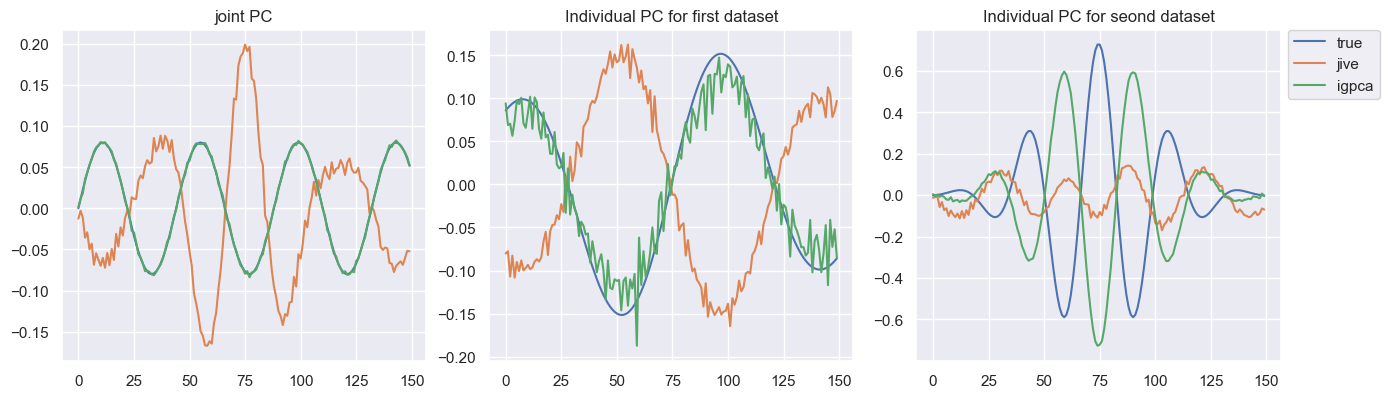

In [104]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
plt.tight_layout(h_pad=2)
axes[0].plot(U0_true, label='true')
axes[0].plot(u0_jive, label='jive')
axes[0].plot(u0_igpca, label='igpca')
axes[0].set_title("joint PC")
axes[1].plot(U1_true, label='true')
axes[1].plot(u1_igpca, label='jive')
axes[1].plot(u1_jive, label='igpca')
axes[1].set_title("Individual PC for first dataset")
axes[2].plot(U2_true, label='true')
axes[2].plot(u2_jive, label='jive')
axes[2].plot(u2_igpca, label='igpca')
axes[2].set_title("Individual PC for seond dataset")
axes[2].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

#### Variable for X1

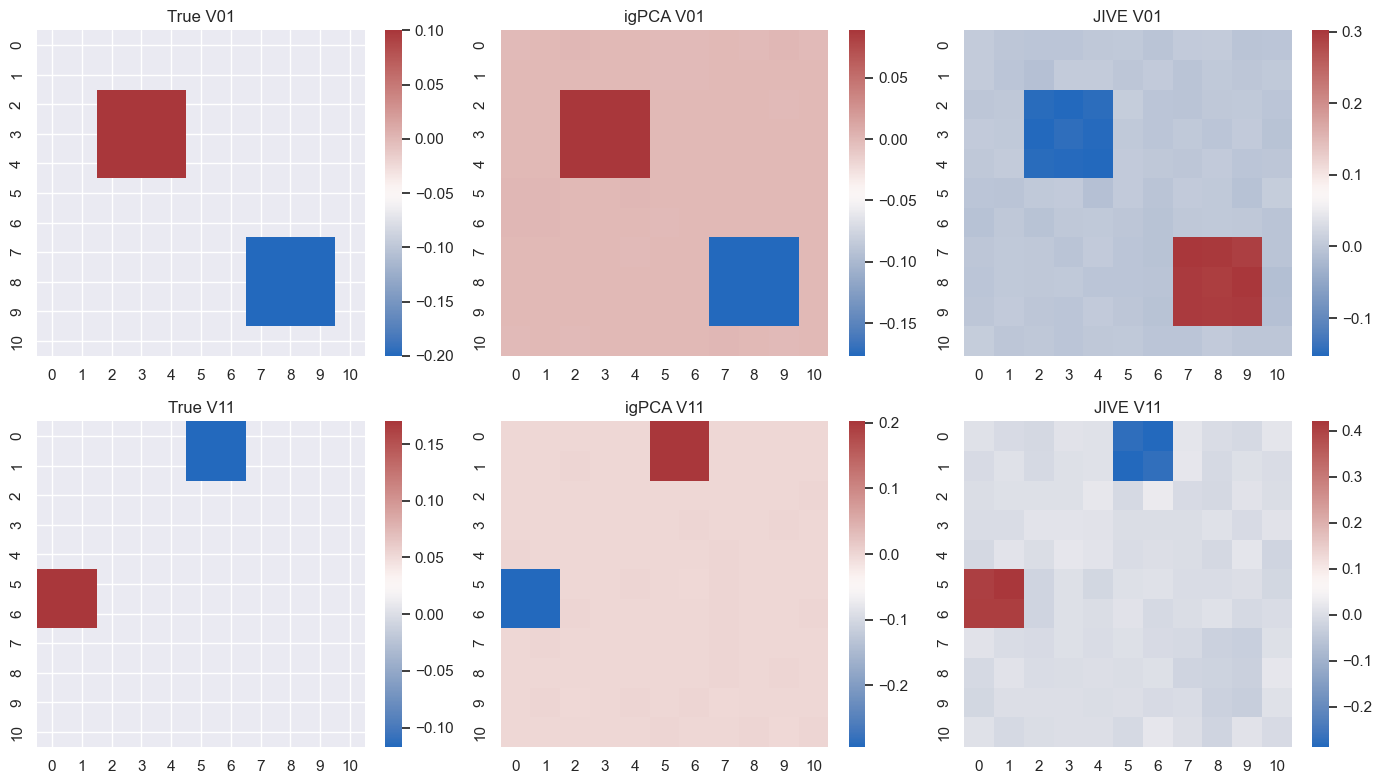

In [105]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
plt.tight_layout(h_pad=2)
sns.heatmap(V1[:,0].reshape(11,11), ax=axes[0, 0], cbar=True, cmap=sns.color_palette("vlag", as_cmap=True),mask=(V1[:,0].reshape(11,11)==0))
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('')
axes[0, 0].set_title('True V01')
sns.heatmap(v01_igpca.reshape(11,11), ax=axes[0, 1], cbar=True, cmap= sns.color_palette("vlag", as_cmap=True),mask=(v01_igpca.reshape(11,11)==0))
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].set_title('igPCA V01')
sns.heatmap(v01_jive.reshape(11,11), ax=axes[0, 2], cbar=True, cmap= sns.color_palette("vlag", as_cmap=True),mask=(v01_jive.reshape(11,11)==0))
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 2].set_title('JIVE V01')
sns.heatmap(V1[:,1].reshape(11,11), ax=axes[1, 0], cbar=True, cmap = sns.color_palette("vlag", as_cmap=True),mask=(V1[:,1].reshape(11,11)==0))
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('')
axes[1, 0].set_title('True V11')
sns.heatmap(v11_igpca.reshape(11,11), ax=axes[1, 1], cbar=True, cmap= sns.color_palette("vlag", as_cmap=True),mask=(v11_igpca.reshape(11,11)==0))
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('')
axes[1, 1].set_title('igPCA V11')
sns.heatmap(v11_jive.reshape(11,11), ax=axes[1, 2], cbar=True,cmap= sns.color_palette("vlag", as_cmap=True),mask=(v11_jive.reshape(11,11)==0))
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('')
axes[1, 2].set_title('JIVE V11')
plt.tight_layout()
plt.show()